In [1]:
#Note all .csv over 50 mb in size are compresed to save space. They must be decompressed before running the code
#Import climate change droughts data (all tweets from Mecodify)
import numpy as np
import pandas as pd
import hashlib
import pylab
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from PIL import Image
import io

all_cases=['combined','droughts','heatwaves','floods']
cases=all_cases

In [2]:
############
#The code in this block is only used on the raw data and NOT in the public version (to protect personal data)

def hash_str(string):
    return hashlib.md5(string).hexdigest()

for case in cases:
    df = pd.read_csv('private/'+case+'_raw_data.csv',encoding="utf8", lineterminator='\n',  low_memory=False)
    df =df[['date_time','user_id','tweet_id','clear_text','retweets','hashtags']]
    df['user_id'] =df['user_id'].astype(str).str.encode('UTF-8').apply(hash_str)
    df.to_csv('data/'+case+'_tweets_redacted.csv', index=False)
###########

In [3]:
#Generate data and graphs for Development of tweeting (including retweets) 2008–2017, comparing the three extreme events
dfs={}

for case in cases:
    dfs[case]=pd.read_csv('data/'+case+'_tweets_redacted.csv',encoding="utf8",
                          dtype={0:'str',1:'str',2:'int64',3:'str',4:'int32',5:'str'},lineterminator='\n')
    dfs[case]['Year']=dfs[case].date_time.str.extract(r'([0-9][0-9][0-9][0-9])', expand=True)
    dfs[case]['Month']=dfs[case].date_time.str.extract(r'([0-9][0-9][0-9][0-9]-[0-9][0-9])', expand=True)
    dfs[case]['Day']=dfs[case].date_time.str.extract(r'([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9])', expand=True)
    dfs[case]['Hour']=dfs[case].date_time.str.extract(r'([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9] [0-9][0-9])', expand=True)
    dfs[case].to_csv('data/'+case+'_tweets_redacted.csv', index=False) 


In [4]:
def my_agg(x,series):
    names = { series+'_users': x['user_id'].nunique(), series+'_original_tweets': x['tweet_id'].count(), series+'_retweets':  x['retweets'].sum() }
    return pd.Series(names, index=[series+'_users', series+'_original_tweets', series+'_retweets'])


In [5]:
cases=cases[1:]

#The table with the sum of tweets and unique users
variables=['extreme_event','users','original_tweets','retweets','w_retweets']

table_freq = pd.DataFrame([],columns = variables)
#table_1.set_index('extreme_event', inplace=True)

total_users=0
total_original_tweets=0
total_retweets=0
total_w_retweets=0
cases2=cases[0:3]
for case in cases2:
    users=dfs[case]['user_id'].nunique()
    original_tweets=dfs[case]['tweet_id'].count()
    retweets=dfs[case]['retweets'].sum()
    w_retweets=original_tweets+retweets
    table_freq=table_freq.append([pd.Series([case,users,original_tweets,retweets,w_retweets],index=table_freq.columns)], ignore_index=True)
    total_users=total_users+users
    total_original_tweets=total_original_tweets+original_tweets
    total_retweets=total_retweets+retweets
    total_w_retweets=total_w_retweets+w_retweets
        
table_freq=table_freq.append([pd.Series(["Total",total_users,total_original_tweets,
                                  total_retweets,total_w_retweets],index=table_freq.columns)], ignore_index=True)

table_freq.to_csv('data/Table_3_frequencies.csv', index=False)


In [6]:
table1={}
for case in cases:
    table1[case]=dfs[case].groupby('Year').apply(my_agg,case)
    table1[case][case+'_w_retweets']=table1[case][case+'_original_tweets']+table1[case][case+"_retweets"]
    table1[case]=table1[case][[case+'_users',case+'_original_tweets',case+'_w_retweets']]

In [7]:
final_table1=table1['droughts'].merge(table1['heatwaves'], on="Year", how="inner")
final_table1=final_table1.merge(table1['floods'], on="Year", how="inner")

In [8]:
#Save table1 to CSV file
final_table1.to_csv("figures/data/Fig1_and_2.csv")

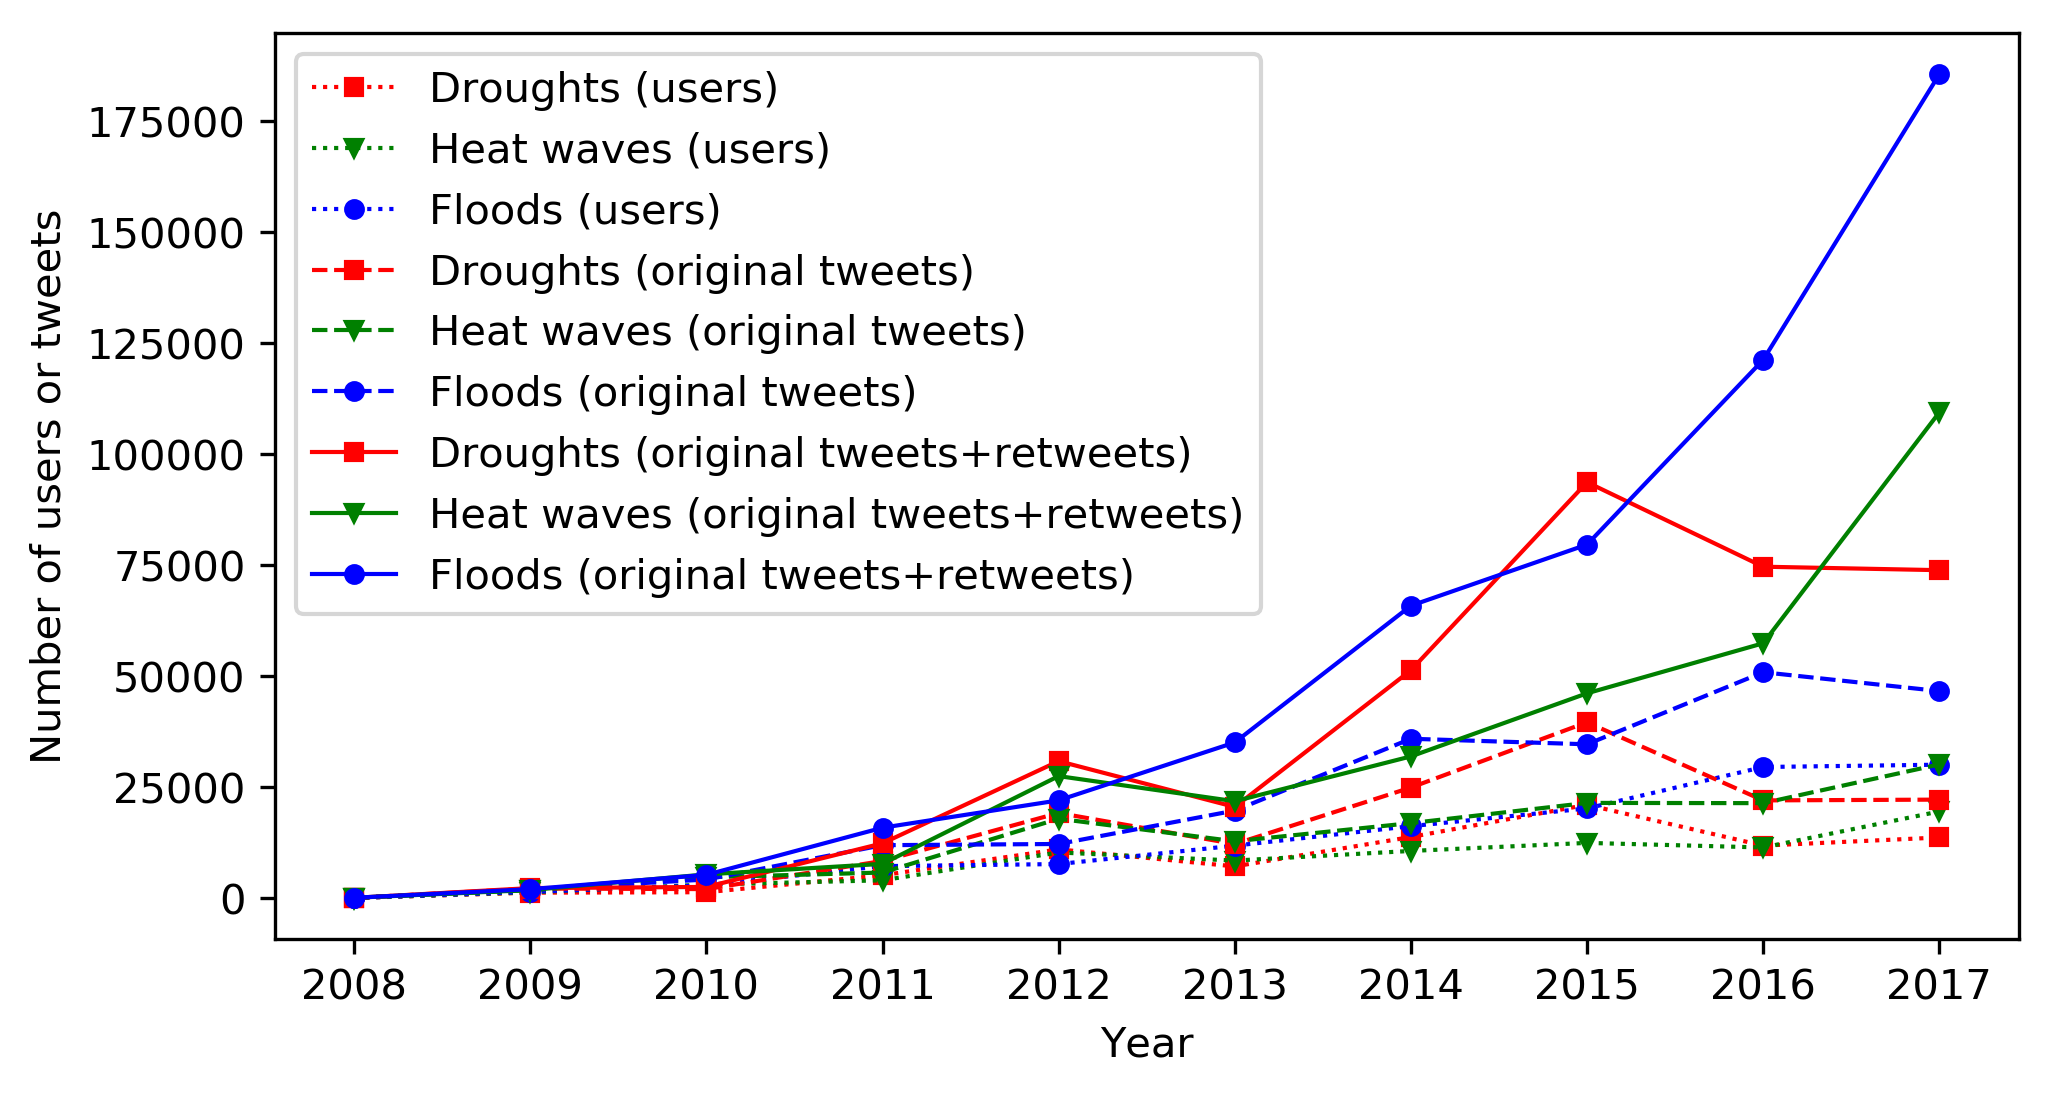

In [9]:
#Plot figure 1 showing twitter activity across the years
df = pd.read_csv("figures/data/Fig1_and_2.csv")
fig=figure(num=None, figsize=(7.5, 4), dpi=300, facecolor='w', edgecolor='k')

plt.plot(df['Year'],df['droughts_users'], marker='s', linewidth=1, markersize=4, linestyle=':', color='r', label="Droughts (users)")
plt.plot(df['Year'],df['heatwaves_users'], marker='v', linewidth=1, markersize=4, linestyle=':', color='g', label="Heat waves (users)")
plt.plot(df['Year'],df['floods_users'], marker='o', linewidth=1, markersize=4, linestyle=':', color='b', label="Floods (users)")
plt.plot(df['Year'],df['droughts_original_tweets'], linewidth=1, markersize=4, linestyle='--', marker='s', color='r', label="Droughts (original tweets)")
plt.plot(df['Year'],df['heatwaves_original_tweets'], linewidth=1, markersize=4, linestyle='--', marker='v', color='g', label="Heat waves (original tweets)")
plt.plot(df['Year'],df['floods_original_tweets'], linewidth=1, markersize=4, linestyle='--', marker='o', color='b', label="Floods (original tweets)")
plt.plot(df['Year'],df['droughts_w_retweets'], linewidth=1, markersize=4, marker='s', color='r', label="Droughts (original tweets+retweets)")
plt.plot(df['Year'],df['heatwaves_w_retweets'], linewidth=1, markersize=4, marker='v', color='g', label="Heat waves (original tweets+retweets)")
plt.plot(df['Year'],df['floods_w_retweets'], linewidth=1, markersize=4, marker='o', color='b', label="Floods (original tweets+retweets)")
plt.xticks(df['Year'])
plt.legend(loc='upper left')
plt.ylabel ('Number of users or tweets')
plt.xlabel ('Year')

plt.rcParams.update({'font.size': 8})

plt.show()

png1 = io.BytesIO()
fig.savefig(png1, format="png", bbox_inches = 'tight', pad_inches = 0)
png2 = Image.open(png1)
png2.save("figures/Fig1.tif")
png1.close()


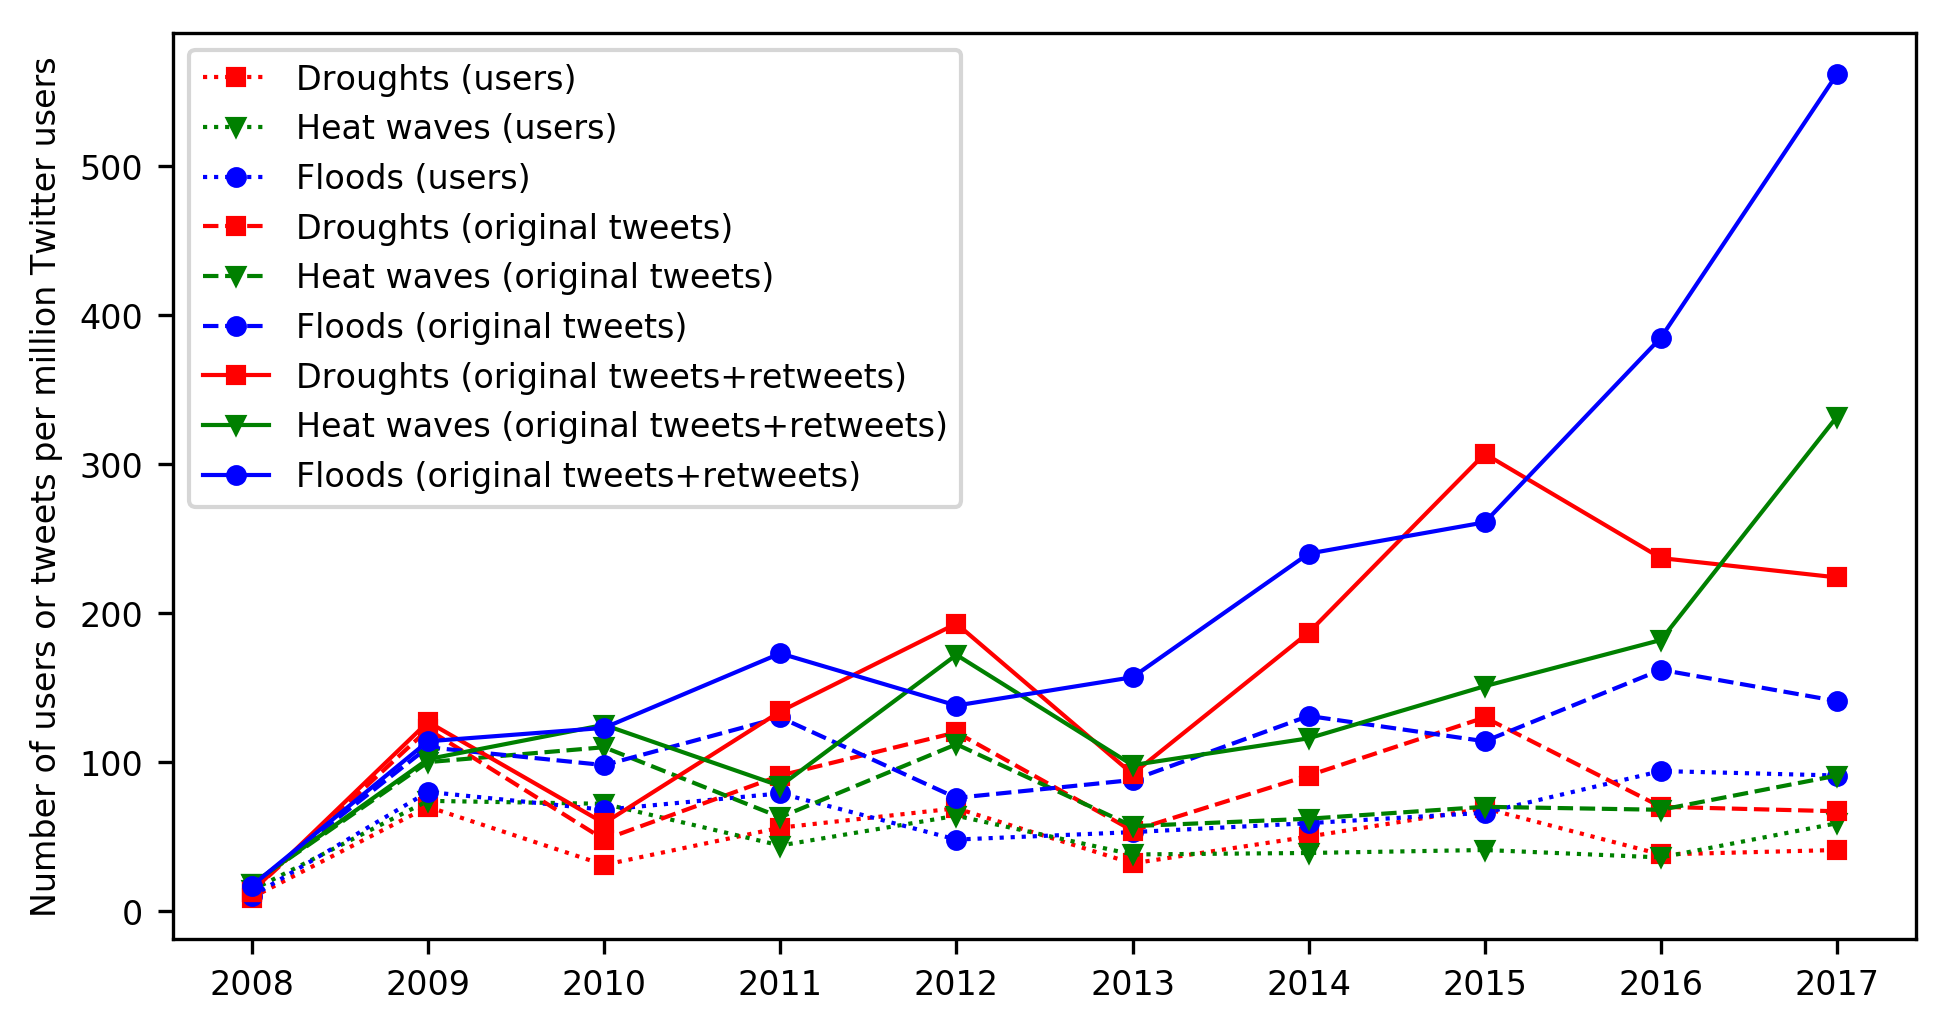

In [10]:
#Plot figure 2 reppresenting twitter activity adjusted for expansion of Twitter base
#Source: Data from The Balance https://www.thebalance.com/twitter-statistics-2008-2009-2010-2011-3515899 

df = pd.read_csv("figures/data/Fig1_and_2.csv")

twitter_base={"2008":6, "2009":18, "2010":43, "2011":92, "2012":160, 
              "2013":224, "2014":275, "2015":305, "2016":315, "2017":330}

for yr in range(2008, 2018):
    for case in cases:
        for index, row in df.iterrows():
            if (int(row['Year'])==yr):
                row[case+'_users']=round(row[case+'_users']/twitter_base[str(yr)])
                row[case+'_original_tweets']=round(row[case+'_original_tweets']/twitter_base[str(yr)])
                row[case+'_w_retweets']=round(row[case+'_w_retweets']/twitter_base[str(yr)])

fig=figure(num=None, figsize=(7.5, 4), dpi=300, facecolor='w', edgecolor='k')

plt.plot(df['Year'],df['droughts_users'], linewidth=1, markersize=4, marker='s', linestyle=':', color='r', label="Droughts (users)")
plt.plot(df['Year'],df['heatwaves_users'], linewidth=1, markersize=4, marker='v', linestyle=':', color='g', label="Heat waves (users)")
plt.plot(df['Year'],df['floods_users'], linewidth=1, markersize=4, marker='o', linestyle=':', color='b', label="Floods (users)")
plt.plot(df['Year'],df['droughts_original_tweets'], linewidth=1, markersize=4, linestyle='--', marker='s', color='r', label="Droughts (original tweets)")
plt.plot(df['Year'],df['heatwaves_original_tweets'], linewidth=1, markersize=4, linestyle='--', marker='v', color='g', label="Heat waves (original tweets)")
plt.plot(df['Year'],df['floods_original_tweets'], linewidth=1, markersize=4, linestyle='--', marker='o', color='b', label="Floods (original tweets)")
plt.plot(df['Year'],df['droughts_w_retweets'], linewidth=1, markersize=4, marker='s', color='r', label="Droughts (original tweets+retweets)")
plt.plot(df['Year'],df['heatwaves_w_retweets'], linewidth=1, markersize=4, marker='v', color='g', label="Heat waves (original tweets+retweets)")
plt.plot(df['Year'],df['floods_w_retweets'], linewidth=1, markersize=4, marker='o', color='b', label="Floods (original tweets+retweets)")
plt.xticks(df['Year'])
plt.legend(loc='upper left')
plt.ylabel ('Number of users or tweets per million Twitter users')

plt.rcParams.update({'font.size': 8})

plt.show()
png1 = io.BytesIO()
fig.savefig(png1, format="png", bbox_inches = 'tight', pad_inches = 0)
png2 = Image.open(png1)
png2.save("figures/Fig2.tif")
png1.close()


In [11]:
#Pull the hourly data for all cases:
table2={}
for case in cases:
    table2[case]=dfs[case].groupby('Hour').apply(my_agg,case)

In [12]:
for case in cases:
    table2[case][case+'_tweets_total']=table2[case][case+'_original_tweets']+table2[case][case+'_retweets']

In [13]:
#Print them to files
for case in cases:
    table2[case].to_csv("data/"+case+"_hourly_activity.csv")

In [14]:
table2={}
for case in cases:
    table2[case] = pd.read_csv('data/'+case+'_hourly_activity.csv')

In [15]:

def spike_detection(y, lag, threshold):
    signals = [0]*len(y)
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(lag, len(y)):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:
            signals[i] = 1
            filteredY[i] = y[i]
        else:
            signals[i] = 0
            filteredY[i] = y[i]
        avgFilter[i] = np.mean(filteredY[(i-lag):i])
        stdFilter[i] = np.std(filteredY[(i-lag):i])
            
    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))

In [16]:
# Run algo with settings of 24 hours for lag and 2 for threshold
table2_spikes={}

for case in cases:
    table2_spikes[case] = pd.DataFrame([],columns = ['Hour',case+'_tweets',case+'_spike',case+'_mean',case+'_std'])
    table2_spikes[case]['Hour']=table2[case]['Hour']
    table2_spikes[case][case+'_tweets']=table2[case][case+'_tweets_total']
    table2_spikes[case]['Year']=table2_spikes[case].Hour.str.extract(r'([0-9][0-9][0-9][0-9])', expand=True)
    result = spike_detection(table2[case][case+'_tweets_total'], 25, 2)
    table2_spikes[case][case+'_spike']=result['signals']
    table2_spikes[case][case+'_mean']=result['avgFilter']
    table2_spikes[case][case+'_std']=result['stdFilter']

    table2_spikes[case].to_csv("data/"+case+"_hourly_activity_with_spikes.csv", index=False)


In [17]:
def my_agg2(x,series):
    names = { series+'_spikes': x[series+'_tweets'].count(),series+'_spike_avg':  x[case+'_tweets'].mean()  }
    return pd.Series(names, index=[series+'_spikes', series+"_spike_avg"])

In [18]:
temp_table={}
temp_table=table2_spikes
table2_grouped={}
for case in cases:
    temp_table[case]=temp_table[case].query(case+'_spike==1')
    table2_grouped[case]=temp_table[case].groupby('Year').apply(my_agg2,case)

In [19]:
for case in cases:
    final_table2=table2_grouped['droughts'].merge(table2_grouped['heatwaves'], on="Year", how="inner")
    final_table2=final_table2.merge(table2_grouped['floods'], on="Year", how="inner")


In [20]:
final_table2.to_csv("figures/data/Fig3_and_4.csv")

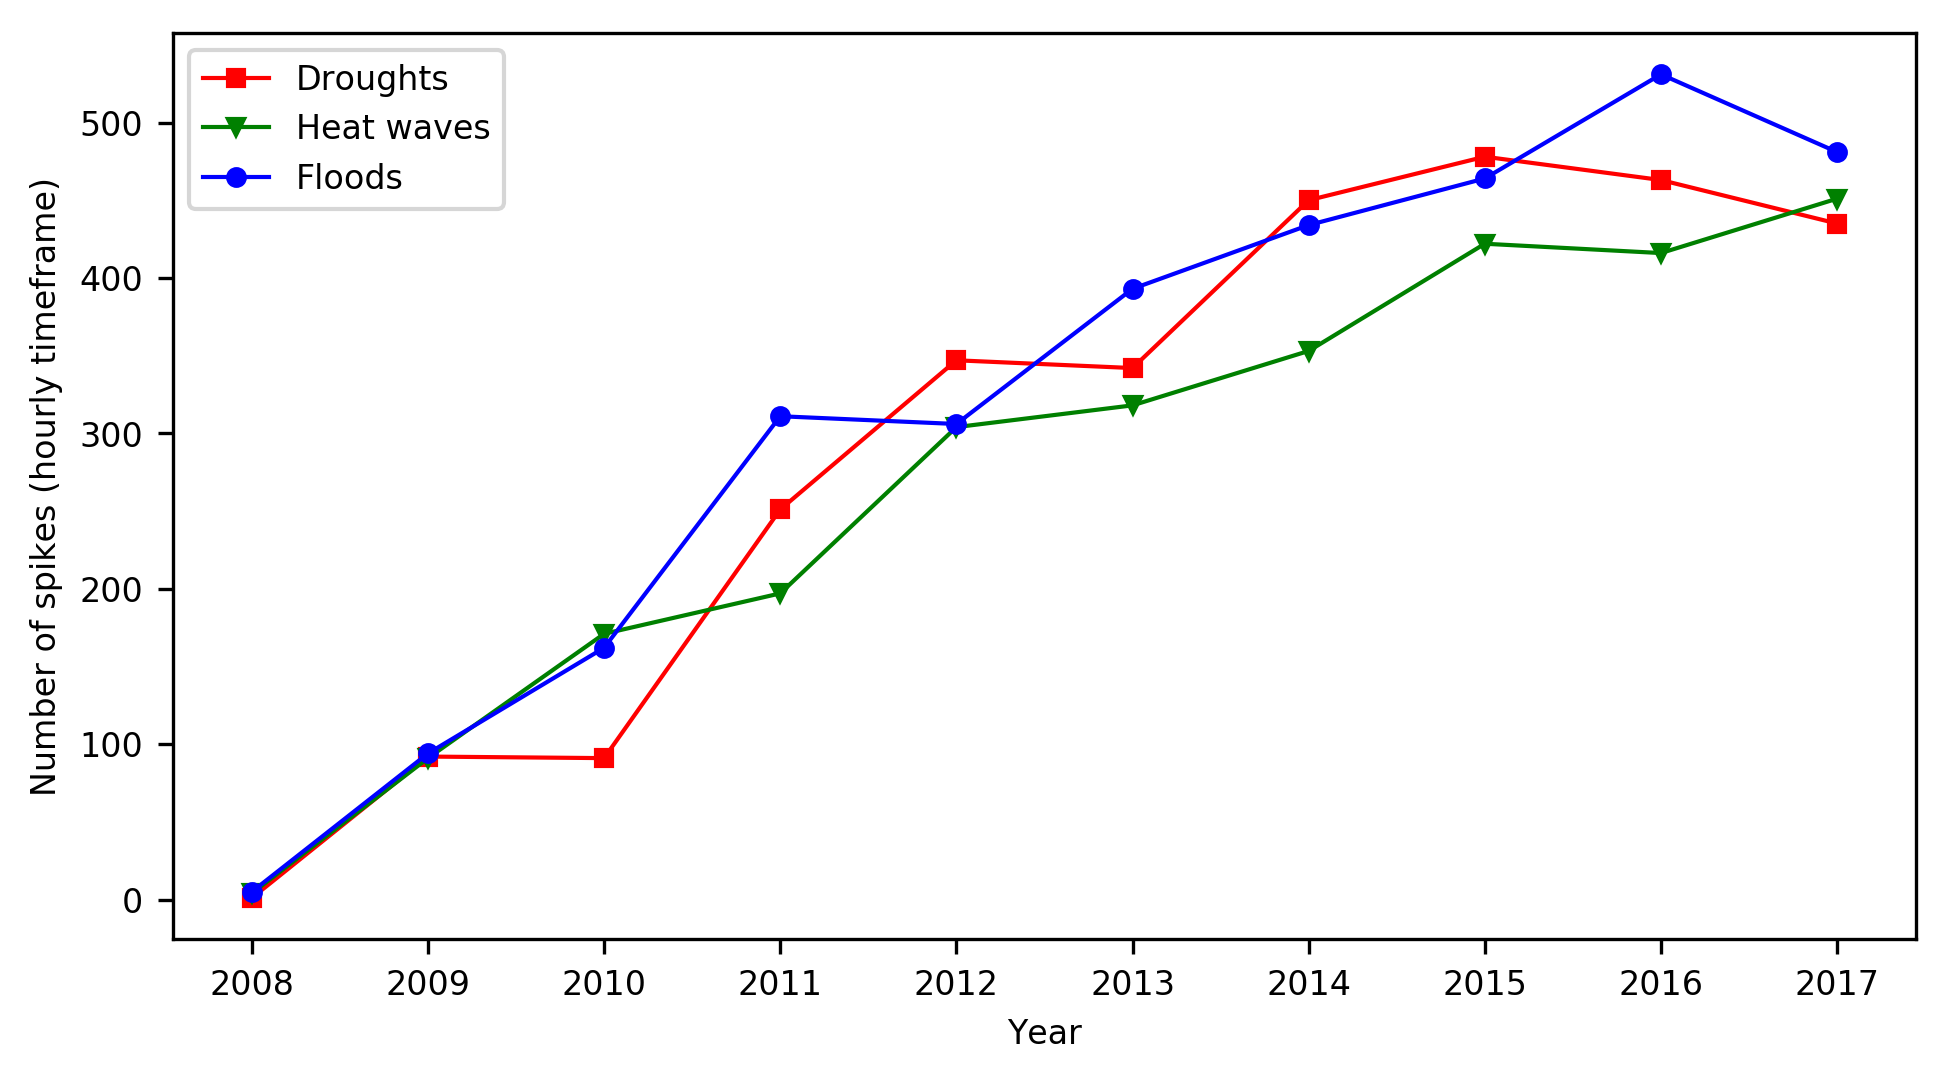

In [21]:
#Plot figure 3 using the data above
df = pd.read_csv("figures/data/Fig3_and_4.csv")

fig=figure(num=None, figsize=(7.5, 4), dpi=300, facecolor='w', edgecolor='k')

plt.plot(df['Year'],df['droughts_spikes'], linewidth=1, markersize=4, marker='s', color='r', label="Droughts")
plt.plot(df['Year'],df['heatwaves_spikes'], linewidth=1, markersize=4, marker='v', color='g', label="Heat waves")
plt.plot(df['Year'],df['floods_spikes'], linewidth=1, markersize=4, marker='o', color='b', label="Floods")
plt.xticks(df['Year'])
plt.legend(loc='upper left')
plt.ylabel ('Number of spikes (hourly timeframe)')
plt.xlabel ('Year')

plt.rcParams.update({'font.size': 8})

plt.show()
png1 = io.BytesIO()
fig.savefig(png1, format="png", bbox_inches = 'tight', pad_inches = 0)
png2 = Image.open(png1)
png2.save("figures/Fig3.tif")
png1.close()

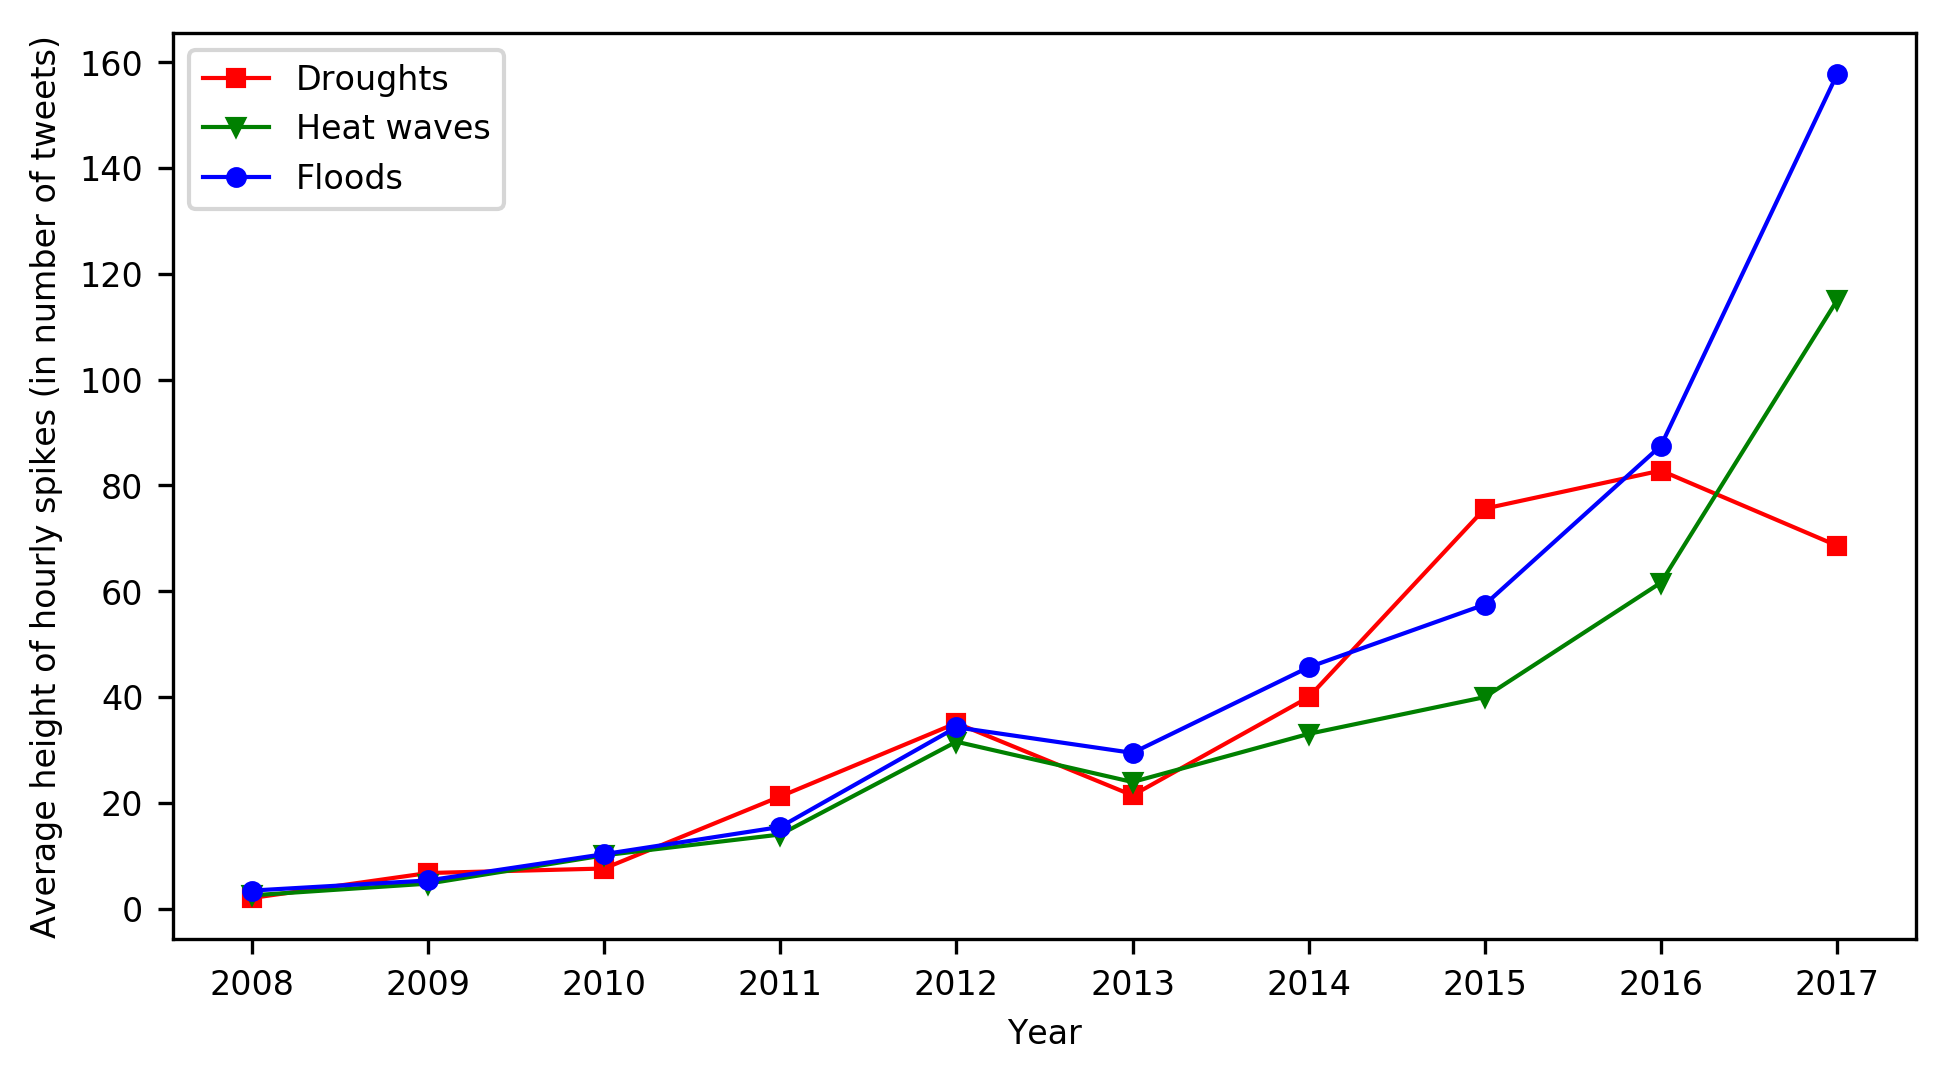

In [22]:
#Plot figure 4 (average hourly spike heights) using the data above

df = pd.read_csv("figures/data/Fig3_and_4.csv")

fig=figure(num=None, figsize=(7.5, 4), dpi=300, facecolor='w', edgecolor='k')

plt.plot(df['Year'],df['droughts_spike_avg'], linewidth=1, markersize=4, marker='s', color='r', label="Droughts")
plt.plot(df['Year'],df['heatwaves_spike_avg'], linewidth=1, markersize=4, marker='v', color='g', label="Heat waves")
plt.plot(df['Year'],df['floods_spike_avg'], linewidth=1, markersize=4, marker='o', color='b', label="Floods")
plt.xticks(df['Year'])
plt.legend(loc='upper left')
plt.ylabel ('Average height of hourly spikes (in number of tweets)')
plt.xlabel ('Year')

plt.rcParams.update({'font.size': 8})

plt.show()
png1 = io.BytesIO()
fig.savefig(png1, format="png", bbox_inches = 'tight', pad_inches = 0)
png2 = Image.open(png1)
png2.save("figures/Fig4.tif")
png1.close()

In [23]:
temp_table={}
for case in cases:
    temp_table[case]=pd.read_csv("data/"+case+"_hourly_activity_with_spikes.csv",index_col="Hour")
    temp_table[case]=temp_table[case].drop('Year', 1)
    temp_table[case]=temp_table[case].drop(case+'_mean', 1)
    temp_table[case]=temp_table[case].drop(case+'_std', 1)

grouped_spikes=temp_table["droughts"].merge(temp_table["heatwaves"], on="Hour", how="outer")
grouped_spikes=grouped_spikes.merge(temp_table["floods"], on="Hour", how="outer")

In [24]:
grouped_spikes.head()
grouped_spikes.to_csv("figures/data/Fig5.csv")

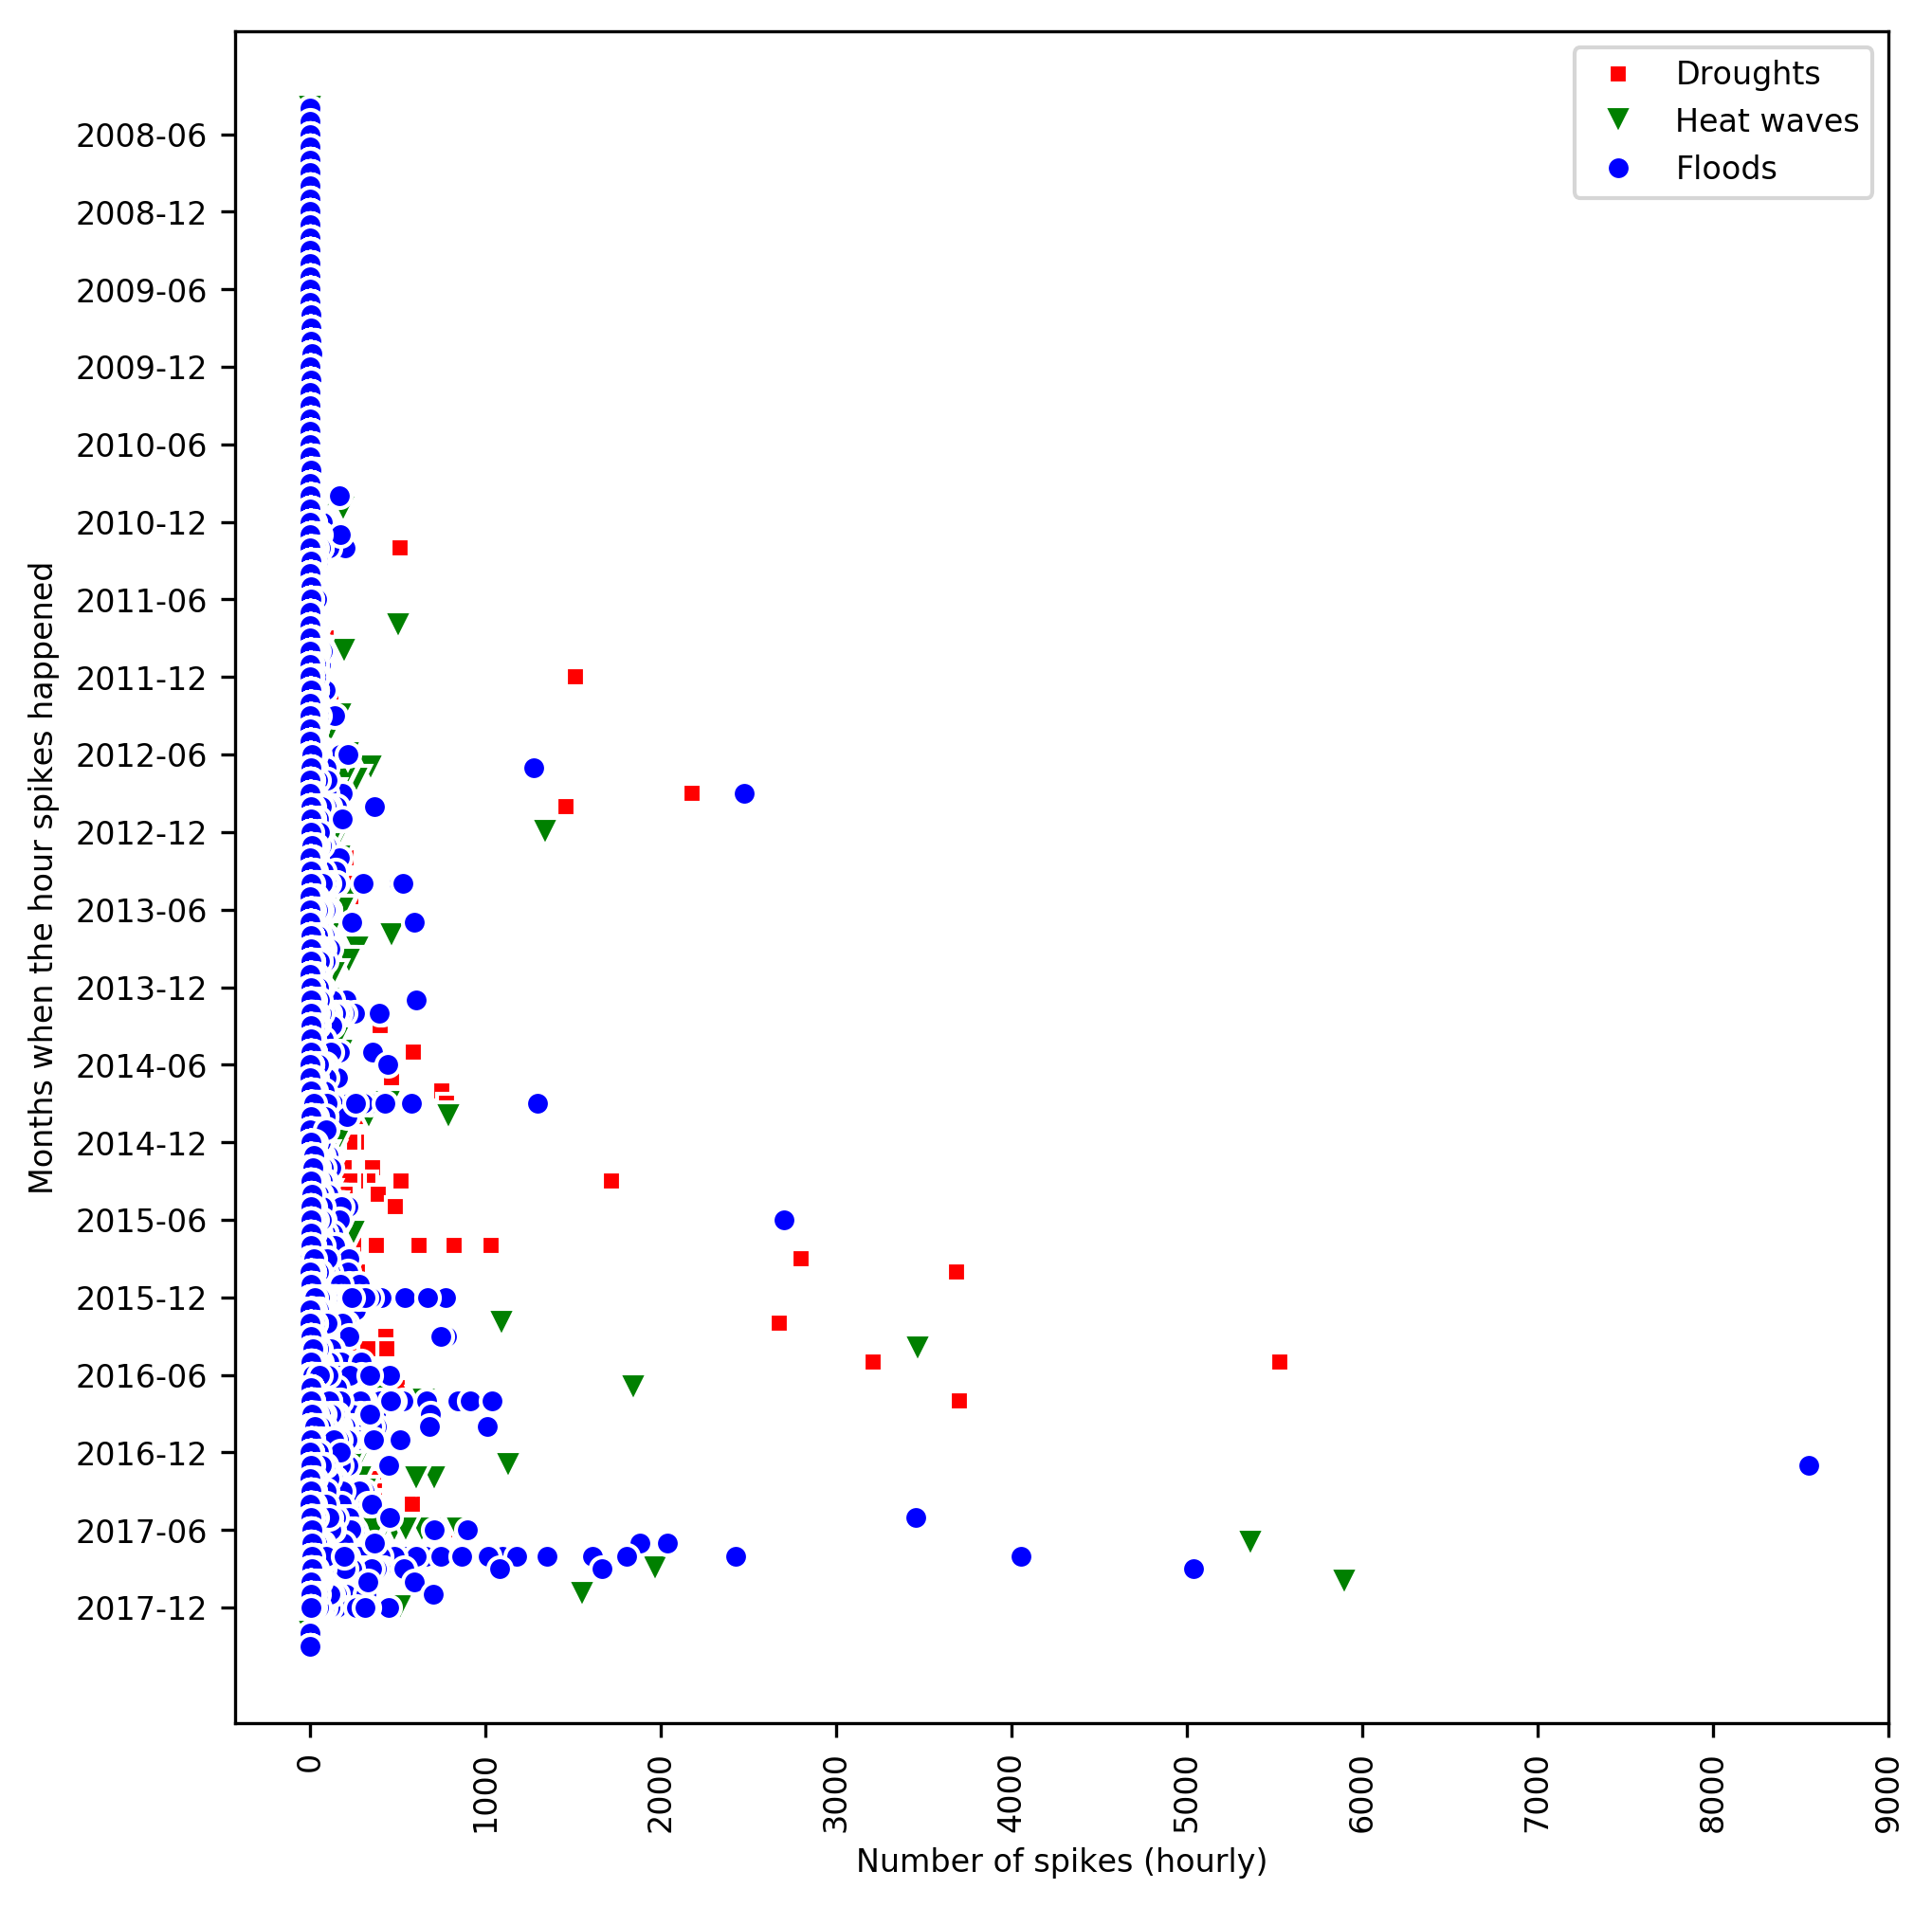

In [36]:
#Plot figures 5:a showing actual hourly drought spikes
fig=figure(num=None, figsize=(7.5, 8.75), dpi=300, facecolor='w', edgecolor='k')

fig.subplots_adjust(bottom=0.2)

df = pd.read_csv("figures/data/Fig5.csv")
df['Hour']=df['Hour'].str.extract(r'([0-9][0-9][0-9][0-9]-[0-9][0-9])', expand=True)
plt.plot(df['droughts_tweets'],df['Hour'], marker='s', color='white', label="Droughts", linewidth=0, markersize=5, markerfacecolor='red')
plt.plot(df['heatwaves_tweets'],df['Hour'], marker='v', color='white', label="Heat waves", linewidth=0, markersize=7, markerfacecolor='green')
plt.plot(df['floods_tweets'],df['Hour'], marker='o', color='white', label="Floods", linewidth=0, markersize=6, markerfacecolor='blue')

hr=df['Hour'].unique()
hr=['2008-06','2008-12',
    '2009-06','2009-12',
    '2010-06','2010-12',
    '2011-06','2011-12',
    '2012-06','2012-12',
    '2013-06','2013-12',
    '2014-06','2014-12',
    '2015-06','2015-12',
    '2016-06','2016-12',
    '2017-06','2017-12']
plt.yticks(hr, fontsize=8)
plt.xticks(np.linspace(0,9000,10), rotation='vertical')

plt.legend(loc='upper right')
plt.xlabel ('Number of spikes (hourly)')
plt.ylabel ('Months when the hour spikes happened')
plt.gca().invert_yaxis()

plt.rcParams.update({'font.size': 8})

plt.show()

png1 = io.BytesIO()
fig.savefig(png1, format="png", bbox_inches = 'tight', pad_inches = 0)
png2 = Image.open(png1)
png2.save("figures/Fig5.tif")
png1.close()

In [26]:
cases=all_cases
table4={}
peaks={}

for case in cases:
    table4[case]=dfs[case].groupby('Month').apply(my_agg,case)
    table4[case][case+'_tweets']=table4[case][case+'_original_tweets']+table4[case][case+"_retweets"]
    table4[case]['Year']=(table4[case].index).astype(str).str[:-3]
    table_freq = pd.DataFrame([])
    for yr in range(2008,2018):
        tmp_df=table4[case][table4[case]['Year'].str.contains(str(yr))]
        if yr==2008:
            peaks[case]=tmp_df.sort_values(case+'_tweets', ascending=False).head(1)
        else:
            peaks[case]=peaks[case].append(tmp_df.sort_values(case+'_tweets', ascending=False).head(1))
    peaks[case]=peaks[case][[case+'_tweets','Year']]
    peaks[case].to_csv('data/Table4_'+case+'_monthly_peaks.csv')

